In [1]:
# load modules
# for legacy python compatibility
from __future__ import absolute_import, division, print_function, unicode_literals

# # TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# disable GPU and only CPU and Warning etc
import os, sys

import datetime
from SALib.analyze import sobol

# from tensorflow import feature_column
# from sklearn.model_selection import train_test_split
# import pathlib
# import seaborn as sns

import ddmms.help.ml_help as ml_help

import ddmms.preprocess.ml_preprocess as ml_preprocess

import ddmms.parameters.ml_parameters as ml_parameters
import ddmms.parameters.ml_parameters_cnn as ml_parameters_cnn

import ddmms.models.ml_models as ml_models
import ddmms.models.ml_optimizer as ml_optimizer
import ddmms.models.ml_loss as ml_loss

import ddmms.postprocess.ml_postprocess as ml_postprocess
import ddmms.math.ml_math as ml_math
import ddmms.specials.ml_specials as ml_specials

import ddmms.misc.ml_misc as ml_misc
import ddmms.misc.ml_callbacks as ml_callbacks

import ddmms.vis.ml_vis as ml_vis
import ddmms.vis.ml_lrp as ml_lrp
import ddmms.vis.ml_utils as ml_utils

import ddmms.train.ml_kfold as ml_kfold
import socket

print("TensorFlow version: ", tf.__version__)
print(os.getcwd())
args = ml_help.sys_args()

args.configfile = 'cnn-free-energy-m-dns-final.config'

if (socket.gethostname() == 'pc256g'):
    args.platform = 'cpu'
else:
    args.platform = 'gpu'
args.inspect = 0
args.debug = False
args.verbose = 1
args.show = 0

ml_help.notebook_args(args)
config = ml_preprocess.read_config_file(args.configfile, args.debug)
# train_dataset, train_labels, val_dataset, val_labels, test_dataset, test_labels, test_derivative, train_stats = ml_preprocess.load_and_inspect_data(
    # config, args)
dataset, labels, derivative, train_stats = ml_preprocess.load_all_data(config, args)

str_form = config['FORMAT']['PrintStringForm']
epochs = int(config['MODEL']['Epochs'])
batch_size = int(config['MODEL']['BatchSize'])
verbose = int(config['MODEL']['Verbose'])
n_splits = int(config['MODEL']['KFoldTrain'])

the_kfolds = ml_kfold.MLKFold(n_splits, dataset)
train_dataset, train_labels, val_dataset, val_labels, test_dataset, test_labels, test_derivative = the_kfolds.get_next_fold(
    dataset, labels, derivative, final_data=True)

#total_model_numbers = parameter.get_model_numbers()
print("...done with parameters")
model_summary_list = []

config['RESTART']['CheckPointDir'] = './saved_weight'
config['MODEL']['ParameterID'] = ''
checkpoint_dir = config['RESTART']['CheckPointDir'] + config['MODEL']['ParameterID']
model_path = checkpoint_dir + '/' + 'model.h5'

model = ml_models.build_model(config, train_dataset, train_labels)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model

config['RESTART']['RestartWeight'] = 'Y'
epochs = 0

if (config['RESTART']['RestartWeight'].lower() == 'y'):
    print('checkpoint_dir for restart: ', checkpoint_dir)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print("latest checkpoint: ", latest)
    # latest="/opt/scratch/ml/cnn-hyperelasticity-bvp-2d-conv/restart/cp-2000.ckpt"
    if (latest != None):
        model.load_weights(latest)
        print("Successfully load weight: ", latest)
    else:
        print("No saved weights, start to train the model from the beginning!")
        pass

/opt/free/Tensorflow/tf-2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/free/Tensorflow/tf-2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/free/Tensorflow/tf-2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/free/Tensorflow/tf-2.0/lib/python3.6/site-packages/tensorflow/

TensorFlow version:  2.0.0-beta0
/home/xiaoxuan/Dropbox/2-Codes/projects_python/ddmms/paper_results/1-rve-paper/4-cnn-base-free-energy-m-dns/final-cnn-m-dns-v2-understand
... read ... configfile =  cnn-free-energy-m-dns-final.config
old root is: <class 'str'> ['']
...modifying.. DataFile from:  ../../data/cnn-m-dns-base-free-energy/*.vtk,
...modifying.. DataFile to:  /home/xiaoxuan/Dropbox/2-Codes/projects_python/ddmms/paper_results/1-rve-paper/4-cnn-base-free-energy-m-dns/final-cnn-m-dns-v2-understand/../../data/cnn-m-dns-base-free-energy/*.vtk
load_all_data
*****************WARNING**********************:
if have multiple VTK folder and it's the first time to load vtk and save numpy array. There is a
potential bug, that after the 1st vtk folder, the following numpy array file is getting bigger 
and bigger, try to fix this bug next time!!!!!
***********************************************
load_all_data_from_vtk_database
/home/xiaoxuan/Dropbox/2-Codes/projects_python/ddmms/paper_results

In [2]:
metrics = ml_misc.getlist_str(config['MODEL']['Metrics'])
optimizer = ml_optimizer.build_optimizer(config)
loss = ml_loss.build_loss(config)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

callbacks = ml_callbacks.build_callbacks(config)
# print(type(train_dataset))
history = model.fit(
    train_dataset,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_dataset, val_labels),    # or validation_split= 0.1,
    verbose=verbose,
    callbacks=callbacks)
# print(tf.keras.backend.eval(optimizer.lr))
# print(model.optimizer.lr.get_value())

model.summary()

--Decay in exponential rate: initial rate =  0.001 , decay steps =  100 , decay_rate =  0.92
!!!! Caution: use Learning rate with care, there were occasions that tf1.13 should better performance on training. !!!
Avail Optimizer:  ['adam', 'sgd', 'adadelta', 'gradientdescentoptimizer']
Avail Loss:  ['mse', 'mae', 'sparse_categorical_crossentropy', 'binary_crossentropy']
Train on 13600 samples, validate on 1700 samples
Model: "cnn_user_supervise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  90        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1230      
_________________________________________________________________
max_pooling2d_1 (MaxPoo

In [3]:
all_weights = model.get_weights()
print(type(all_weights))
print(all_weights[0])

<class 'list'>
[[[[ 0.07602163 -0.01880752  0.01396543  0.04265527  0.01530066
    -0.10432114 -0.0279536  -0.0225498  -0.06724264]]

  [[-0.16086046  0.02340019  0.03064532 -0.16547589 -0.06455952
    -0.21447279  0.06345093 -0.07974333  0.20230874]]

  [[-0.04203591  0.01946978 -0.12795053  0.1045898   0.07534903
    -0.17011875  0.02985107  0.0712286  -0.09103958]]]


 [[[-0.01341635 -0.01045474 -0.00498581 -0.0085035   0.1039461
    -0.28239334 -0.07225559 -0.0407545   0.153601  ]]

  [[ 0.14799991  0.10632347  0.01853522  0.0277677  -0.0968059
     0.01486046 -0.04228484  0.05904214 -0.04082227]]

  [[ 0.05944447 -0.11432603  0.01144398 -0.20638613  0.00433754
    -0.09209779  0.0719232   0.09266514  0.06940357]]]


 [[[-0.24107936 -0.02245095  0.11653771 -0.03733529  0.07999161
     0.11453234  0.04312678  0.01882729 -0.11189631]]

  [[ 0.29231733  0.02376317 -0.02783814  0.01773102  0.00538017
    -0.14544392 -0.09791135  0.00261834 -0.04883843]]

  [[-0.18964675  0.01811535  0.

In [4]:
print(type(all_weights[0]), tf.shape(all_weights[0]))

<class 'numpy.ndarray'> tf.Tensor([3 3 1 9], shape=(4,), dtype=int32)


In [5]:
for i in range(0,9):
    print(i)
    print(all_weights[0][:,:,0,i])

0
[[ 0.07602163 -0.16086046 -0.04203591]
 [-0.01341635  0.14799991  0.05944447]
 [-0.24107936  0.29231733 -0.18964675]]
1
[[-0.01880752  0.02340019  0.01946978]
 [-0.01045474  0.10632347 -0.11432603]
 [-0.02245095  0.02376317  0.01811535]]
2
[[ 0.01396543  0.03064532 -0.12795053]
 [-0.00498581  0.01853522  0.01144398]
 [ 0.11653771 -0.02783814  0.03056368]]
3
[[ 0.04265527 -0.16547589  0.1045898 ]
 [-0.0085035   0.0277677  -0.20638613]
 [-0.03733529  0.01773102  0.0517944 ]]
4
[[ 0.01530066 -0.06455952  0.07534903]
 [ 0.1039461  -0.0968059   0.00433754]
 [ 0.07999161  0.00538017 -0.02661573]]
5
[[-0.10432114 -0.21447279 -0.17011875]
 [-0.28239334  0.01486046 -0.09209779]
 [ 0.11453234 -0.14544392  0.03038843]]
6
[[-0.0279536   0.06345093  0.02985107]
 [-0.07225559 -0.04228484  0.0719232 ]
 [ 0.04312678 -0.09791135  0.08557769]]
7
[[-0.0225498  -0.07974333  0.0712286 ]
 [-0.0407545   0.05904214  0.09266514]
 [ 0.01882729  0.00261834  0.03113726]]
8
[[-0.06724264  0.20230874 -0.09103958]

In [16]:
filter4 = all_weights[0][:,:,0:1,3:4]
print(filter4)

[[[[ 0.04265527]]

  [[-0.16547589]]

  [[ 0.1045898 ]]]


 [[[-0.0085035 ]]

  [[ 0.0277677 ]]

  [[-0.20638613]]]


 [[[-0.03733529]]

  [[ 0.01773102]]

  [[ 0.0517944 ]]]]


In [28]:
oneM = np.load('m1.npy')
print(np.shape(oneM))
output = tf.nn.conv2d(
    oneM,
    filters=filter4,
    strides=(1,1),
    padding='SAME',
    name='a',
)
output = tf.nn.relu(output)

print(tf.shape(output))
out1 = output[0,:,:,0]

(5, 61, 61, 1)
tf.Tensor([ 5 61 61  1], shape=(4,), dtype=int32)


tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(61, 61), dtype=float32)


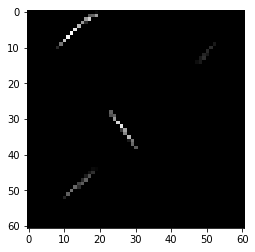

In [29]:
print(out1)
plt.imshow(out1)
plt.gray()
plt.show()